In [1]:
#load required libraries
library(MASS)
library(tidyverse)
library(dndscv)
library(GenomicRanges)
library(cowplot)
library(ggthemes)
library(broom)
library(viridis)
library(Hmisc)
library(jcolors)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Warning message:
“replacing previous import ‘Biostrings::translate’ by ‘seqinr::translate’ when loading ‘dndscv’”Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff

In this notebook I'll use the TCGA combined MAF/CNV files to calculate $dN/dS$ ratios for different mutation clonalities and to also calculate interval $dN/dS$.

### 1 Read in data

In [2]:
df <- read_csv("data/TCGA-combined-hg38-2.csv");

#read in list of drivers
drivers <- read.table("data/genelists/Driver_gene_list_198_Science_Review.txt",
                      header = FALSE) %>%
    filter(V1 != "FAM46C") #this gene is not compatible with dndscv

cellessential <- read.csv("data/genelists/blomen_essential.csv", header = T) %>%  #cell essential genes from Blomen et al
    filter(!(V1 %in% drivers$V1)) %>%
    filter(!(V1 %in% Cs(PET112, IKBKAP, UQCC, SLMO2, SLMO2, ATP5B, PPP2R4, 
                      TOMM70A, ATP5C1, WIBG, C9orf114, C9orf114, ATP5A1, 
                      WBSCR22, ATP5O, SHFM1, GTPBP5, GNB2L1, TOMM70A, SRPR, 
                      CIRH1A, NHP2L1, NUPL1, UFD1L, ZNF259, FAM96B, DIEXF, 
                      SKIV2L2, CCDC94, UTP11L, MKI67IP, NARFL, GLTSCR2, FDX1L))) #genes not compatible with dndscv

randomgenes <- read.table("data/genelists/refcdsgenes.txt", header = TRUE) %>%
    filter(!V1 %in% cellessential$V1, !V1 %in% drivers$V1) %>%
    sample_n(1000)

dfunfilt <- df

df <- df %>%
    mutate(VAFcorr = VAF/cellularity) %>%
    mutate(absCNcorrected = ifelse(absCNcorrected > 5, 5, absCNcorrected)) %>%
    filter(ploidy < 2.5) %>% #remove WGD samples where MCN is likely to be incorrect
    filter(!is.na(cellularity)) %>% #remove samples with no cellularity estimate
    #filter(cellularity < 1.0) %>% #remove samples cellularity estimate = 1 as this is likely incorrect
    filter(mutation_type == "SNV") %>% #only include SNVs
    group_by(sampleid) %>%
    mutate(sampledepth = mean(t_depth)) %>%
    ungroup() %>%
    mutate(cancertype = ifelse(cancertype == "READ", "COAD", cancertype)) %>% #combine COAD and READ
    group_by(sampleid) %>%
    mutate(effectivedepth = cellularity * sampledepth) %>%
    mutate(meaneffdepth = mean(effectivedepth),
          subclonalcutoff = 1.0 - (3 * (sqrt(1/meaneffdepth)))) %>%
    ungroup() %>%
    mutate(clonality = case_when(
                    MCN < 0.5 ~ "Subclonal",
                    MCN > 0.5 & MCN < 1.5 ~ "Clonal",
                    MCN > 1.5 ~ "Amplified"))

Parsed with column specification:
cols(
  .default = col_integer(),
  sampleid = col_character(),
  chr = col_character(),
  Reference_Allele = col_character(),
  Tumor_Seq_Allele2 = col_character(),
  VAF = col_double(),
  cancertype = col_character(),
  mutation_type = col_character(),
  Cancer_Type_Code = col_character(),
  cellularity = col_double(),
  ploidy = col_double(),
  Segment_Mean = col_double(),
  CN = col_double(),
  CNcorrected = col_double(),
  MCN = col_double()
)
See spec(...) for full column specifications.


In [52]:
# print out number of samples per cancer type
df %>%
    filter(effectivedepth > 50.0) %>%
    distinct(sampleid, cancertype) %>%
    group_by(cancertype) %>%
    summarise(n = n()) 

cancertype,n
ACC,22
BLCA,52
BRCA,270
CESC,24
COAD,200
DLBC,9
GBM,253
HNSC,103
KICH,31
KIRC,186


In [50]:
# print out number of samples per cancer type
df %>%
    filter(effectivedepth > 50.0) %>%
    distinct(sampleid, cancertype) %>%
    group_by(cancertype) %>%
    summarise(n = n()) 

cancertype,n
ACC,22
BLCA,42
BRCA,243
CESC,23
COAD,193
DLBC,9
GBM,246
HNSC,86
KICH,30
KIRC,182


### MCN (mutant copy number) plots across cancer types


Warning message:
“Removed 12344 rows containing non-finite values (stat_bin).”Warning message:
“Removed 6 rows containing missing values (geom_bar).”

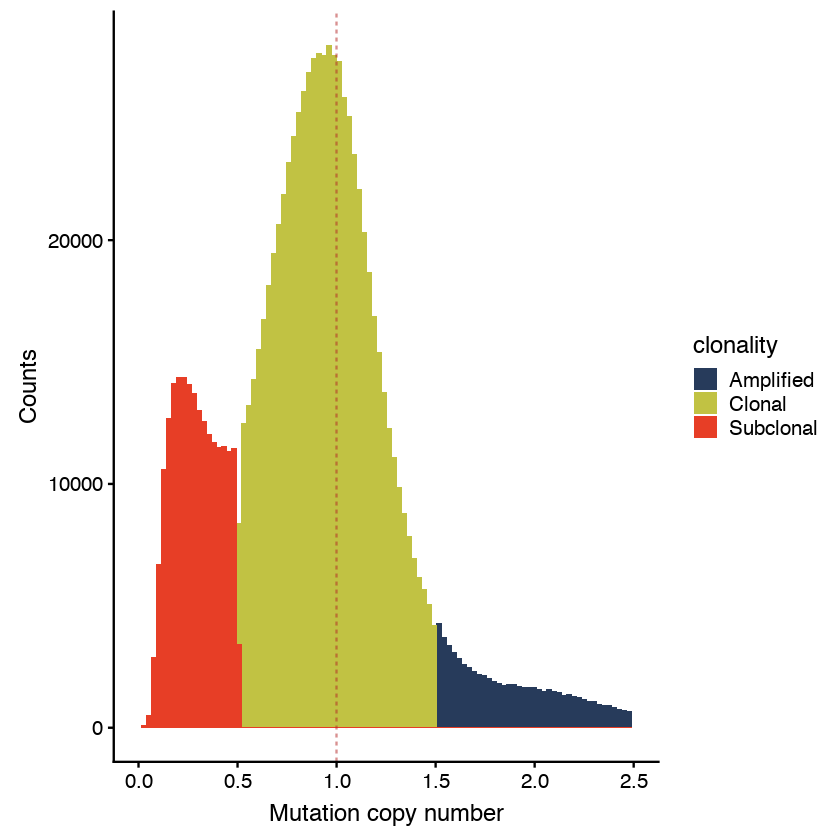

In [59]:
df %>%
    filter(effectivedepth > 50.0) %>%
    na.omit() %>%
    ggplot(aes(x = MCN, fill = clonality)) +
    geom_histogram(bins = 100, position = "identity") +
    geom_vline(xintercept = 1.0, lty = 2, col = "firebrick", alpha = 0.5) +
    xlim(c(0, 2.5)) +
    xlab("Mutation copy number") + ylab("Counts") +
    scale_fill_jcolors(palette = "pal9")

Warning message:
“Removed 12344 rows containing non-finite values (stat_bin).”Warning message:
“Removed 144 rows containing missing values (geom_bar).”

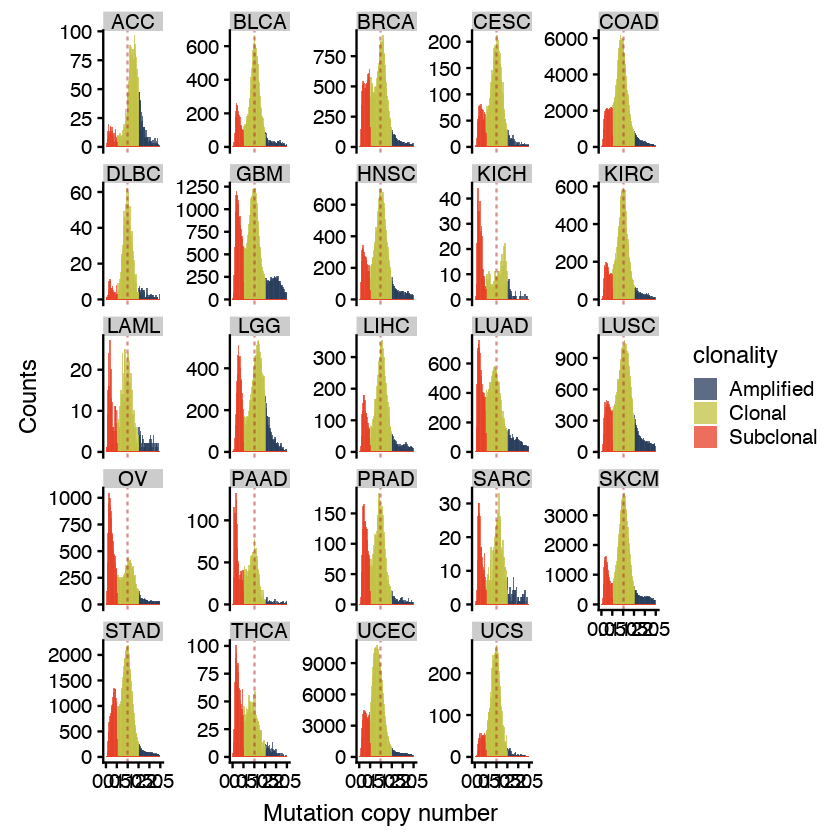

In [61]:
df %>%
    filter(effectivedepth > 50.0) %>%
    na.omit() %>%
    ggplot(aes(x = MCN, fill = clonality)) +
    geom_histogram(bins = 100, alpha = 0.75, position = "identity") +
    geom_vline(xintercept = 1.0, lty = 2, col = "firebrick", alpha = 0.5) +
    xlim(c(0, 2.5)) +
    xlab("Mutation copy number") + ylab("Counts") +
    scale_fill_jcolors(palette = "pal9") +
    facet_wrap(~cancertype, scales = "free_y")


### Calculate background dN/dS in TCGA

dN/dS can be influenced by germline contimnation, we'll calculate a baseline for this cohort to compare against. This can be a problem in particular due to under or over filtering of germline SNPs. Over filtering results in inflated dN/dS, under filterting can result in lower dN/dS than would be expected.

To calculate this background I'll take a bootstrapping approach and select a random selection of genes that are non-drivers and calculate the average dN/dS over multiple sets.

In [30]:
dfback <- df %>%
    select(sampleid, chr, start, Reference_Allele, Tumor_Seq_Allele2, everything())

In [31]:
library(dndscv)
library(Hmisc)
dndsrandom <- data.frame()

for (i in 1:50){
    print(i)
    randomgenestemp <- read.table("data/genelists/refcdsgenes.txt", header = TRUE) %>%
        filter(!V1 %in% cellessential$V1, !V1 %in% drivers$V1) %>%
        sample_n(1000)
    x <- dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, 
                refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(mutationtype = "randomgenes")
    dndsrandom <- rbind(dndsrandom, out)
}

[1] 1


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2037 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 2


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1786 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 3


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2371 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    87% ...
[3] Estimating global rates...


[1] 4


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 6277 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 5


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1908 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 6


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1890 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 7


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2315 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 8


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2841 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 9


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2064 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 10


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1891 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    49% ...
    65% ...
    81% ...
    97% ...
[3] Estimating global rates...


[1] 11


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2362 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1659 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    65% ...
    81% ...
    97% ...
[3] Estimating global rates...


[1] 13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 4090 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    43% ...
    57% ...
    71% ...
    85% ...
    100% ...
[3] Estimating global rates...


[1] 14


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2057 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 15


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2064 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 16


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1668 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1874 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2054 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    87% ...
[3] Estimating global rates...


[1] 19


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2094 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 20


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2258 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 21


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2228 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1679 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1895 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 24


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2282 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    57% ...
    71% ...
    86% ...
    100% ...
[3] Estimating global rates...


[1] 25


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2064 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    89% ...
[3] Estimating global rates...


[1] 26


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1898 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1634 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    63% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1838 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    47% ...
    63% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 29


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2414 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 30


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1787 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 31


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2414 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    87% ...
[3] Estimating global rates...


[1] 32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5286 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    74% ...
    88% ...
[3] Estimating global rates...


[1] 33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1696 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 34


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2330 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    74% ...
    88% ...
[3] Estimating global rates...


[1] 35


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2192 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 36


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1803 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5509 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    44% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1696 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 39


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1880 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 40


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1798 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 41


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2869 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1666 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2310 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 44


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1610 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    47% ...
    63% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 45


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1965 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 46


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2900 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1915 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    63% ...
    78% ...
    94% ...
[3] Estimating global rates...


[1] 48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3304 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 49


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1866 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 50


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1276 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    80% ...
    96% ...
[3] Estimating global rates...


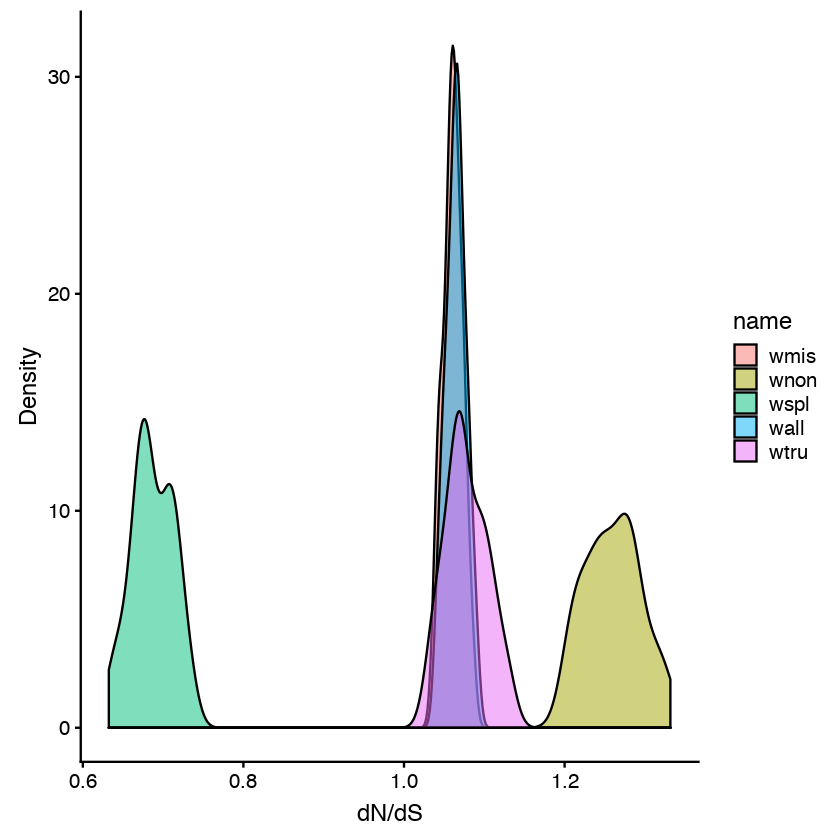

In [32]:
dndsrandom %>%
    ggplot(aes(x = mle, fill = name)) +
    geom_density(alpha = 0.5) +
    xlab("dN/dS") +
    ylab("Density")

In [33]:
baseline <- dndsrandom %>%
    group_by(name) %>%
    summarise(dndslq_bl = quantile(mle, 0.025), dnds_bl = mean(mle), dndsuq_bl = quantile(mle, 0.975))
write_csv(baseline, "FinalFigures/data_for_figures/dNdS_baseline.csv")
baseline

name,dndslq_bl,dnds_bl,dndsuq_bl
wmis,1.0392018,1.0606094,1.0832498
wnon,1.2074508,1.2603777,1.3249290
wspl,0.6368893,0.6867385,0.7300162
wall,1.0418623,1.0648633,1.0880009
wtru,1.0332807,1.0775343,1.1279366


In [34]:
# generate an additional 100 random samples and ensure mean is 1
dndsrandom2 <- data.frame()

for (i in 1:100){
    print(i)
    randomgenestemp <- read.table("data/genelists/refcdsgenes.txt", header = TRUE) %>%
        filter(!V1 %in% cellessential$V1, !V1 %in% drivers$V1) %>%
        sample_n(1000)
    x <- dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, 
                refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(mutationtype = "randomgenes")
    dndsrandom2 <- rbind(dndsrandom2, out)
}

[1] 1


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2100 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 2


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3154 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 3


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3205 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    91% ...
[3] Estimating global rates...


[1] 4


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1580 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    80% ...
    96% ...
[3] Estimating global rates...


[1] 5


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1851 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 6


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1851 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 7


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1813 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 8


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1799 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 9


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2695 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 10


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2116 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 11


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1387 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    63% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2691 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    44% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1443 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 14


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1582 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    63% ...
    79% ...
    94% ...
[3] Estimating global rates...


[1] 15


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1996 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 16


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2026 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1770 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    80% ...
    96% ...
[3] Estimating global rates...


[1] 18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2031 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 19


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1841 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    94% ...
[3] Estimating global rates...


[1] 20


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2411 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 21


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2200 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1738 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1574 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    80% ...
    97% ...
[3] Estimating global rates...


[1] 24


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1895 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    63% ...
    79% ...
    94% ...
[3] Estimating global rates...


[1] 25


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1722 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 26


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2352 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    91% ...
[3] Estimating global rates...


[1] 27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1846 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1810 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 29


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2217 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 30


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2519 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    44% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 31


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2389 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    57% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1643 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    80% ...
    96% ...
[3] Estimating global rates...


[1] 33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2051 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 34


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2557 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 35


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2005 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 36


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2320 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    42% ...
    56% ...
    71% ...
    85% ...
    99% ...
[3] Estimating global rates...


[1] 37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2053 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1835 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 39


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1953 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 40


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5565 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    42% ...
    56% ...
    71% ...
    85% ...
    99% ...
[3] Estimating global rates...


[1] 41


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1710 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1877 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    91% ...
[3] Estimating global rates...


[1] 43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 6089 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    42% ...
    56% ...
    70% ...
    84% ...
    98% ...
[3] Estimating global rates...


[1] 44


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2293 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 45


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2272 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 46


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2151 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2154 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1834 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 49


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1862 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 50


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2884 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    43% ...
    57% ...
    71% ...
    85% ...
    99% ...
[3] Estimating global rates...


[1] 51


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1748 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1817 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2614 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    44% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 54


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2070 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 55


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5705 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 56


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1927 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2558 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2041 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 59


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2701 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 60


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2134 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 61


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2047 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2091 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    58% ...
    72% ...
    87% ...
[3] Estimating global rates...


[1] 63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2262 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 64


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2142 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    91% ...
[3] Estimating global rates...


[1] 65


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2196 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 66


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1956 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2396 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5716 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    94% ...
[3] Estimating global rates...


[1] 69


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2032 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 70


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1742 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 71


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2006 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    62% ...
    78% ...
    93% ...
[3] Estimating global rates...


[1] 72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2074 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2456 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 74


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1740 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 75


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2829 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


[1] 76


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1836 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2073 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1813 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    64% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 79


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 6050 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    57% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 80


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1447 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    32% ...
    48% ...
    63% ...
    79% ...
    95% ...
[3] Estimating global rates...


[1] 81


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3510 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1958 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2631 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 84


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2235 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 85


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1702 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    93% ...
[3] Estimating global rates...


[1] 86


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2063 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    57% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3588 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    28% ...
    43% ...
    57% ...
    71% ...
    85% ...
    100% ...
[3] Estimating global rates...


[1] 88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2611 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    74% ...
    88% ...
[3] Estimating global rates...


[1] 89


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1848 mutations removed for exceeding the limit of mutations per gene per sample
    16% ...
    31% ...
    47% ...
    63% ...
    79% ...
    94% ...
[3] Estimating global rates...


[1] 90


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1789 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 91


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1616 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2490 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    44% ...
    59% ...
    74% ...
    89% ...
[3] Estimating global rates...


[1] 93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2243 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 94


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2904 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...


[1] 95


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2285 mutations removed for exceeding the limit of mutations per gene per sample
    14% ...
    29% ...
    43% ...
    57% ...
    72% ...
    86% ...
[3] Estimating global rates...


[1] 96


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2595 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    61% ...
    76% ...
    92% ...
[3] Estimating global rates...


[1] 97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2703 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    45% ...
    60% ...
    75% ...
    90% ...
[3] Estimating global rates...


[1] 98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1997 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    30% ...
    46% ...
    61% ...
    76% ...
    91% ...
[3] Estimating global rates...


[1] 99


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2122 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    31% ...
    46% ...
    62% ...
    77% ...
    92% ...
[3] Estimating global rates...


[1] 100


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dfback, gene_list = randomgenestemp$V1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 2620 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    58% ...
    73% ...
    87% ...
[3] Estimating global rates...


In [35]:
dndsrandom2 %>%
        left_join(., baseline, by = "name") %>%
        mutate(mle = mle - (dnds_bl - 1),
              cilow = cilow - (dnds_bl - 1),
              cihigh = cihigh - (dnds_bl - 1)) %>%
write_csv(., "FinalFigures/data_for_figures/dNdS_baseline_validate.csv")
    

### dN/dS subclonal vs clonal

In [36]:
dfsubc <- df %>%
    filter(meaneffdepth > 50.0) %>% #remove samples with effective depth < 50X
    select(sampleid, chr, start, Reference_Allele, Tumor_Seq_Allele2, everything())

print(length(unique(dfsubc$sampleid)))

write_csv(dfsubc, "FinalFigures/data_for_figures/TCGAmutations_for_dnds_clonality.csv")

dfdnds <- data.frame()

for (clon in c("Subclonal", "Clonal", "Amplified")){
    x1 <- dfsubc %>% filter(clonality == clon)
    
    x <- dndscv(x1 , gene_list = as.character(drivers$V1), outp = 1,
               refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(clonality = clon, mutationtype = "drivers")
    dfdnds <- rbind(dfdnds, out)
    print(clon)
    print(out)
    
    x <- dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1,
               refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(clonality = clon, mutationtype = "cellessential")
    dfdnds <- rbind(dfdnds, out)
    
    x <- dndscv(x1, outp = 1,
               refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(clonality = clon, mutationtype = "all")
    dfdnds <- rbind(dfdnds, out)
}

dfdnds <- dfdnds %>%
    mutate(clonality = factor(clonality, 
                              levels = c("Subclonal", "Clonal", "Amplified")))

[1] 2619


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 14 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...


[1] "Subclonal"
  name      mle     cilow   cihigh clonality mutationtype
1 wmis 1.301226 1.1887701 1.424320 Subclonal      drivers
2 wnon 2.492821 2.1305445 2.916698 Subclonal      drivers
3 wspl 1.125045 0.8625158 1.467482 Subclonal      drivers
4 wtru 2.006855 1.7399483 2.314706 Subclonal      drivers
5 wall 1.366820 1.2501703 1.494353 Subclonal      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 18 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndsc

[1] "Clonal"
  name      mle    cilow   cihigh clonality mutationtype
1 wmis 1.363730 1.299535 1.431096    Clonal      drivers
2 wnon 3.118913 2.886016 3.370604    Clonal      drivers
3 wspl 1.363666 1.193458 1.558148    Clonal      drivers
4 wtru 2.519415 2.345925 2.705736    Clonal      drivers
5 wall 1.476691 1.408281 1.548424    Clonal      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 385 mutations removed for exceeding the limit of mutations per gene per sample
    42% ...
    84% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, r

[1] "Amplified"
  name      mle    cilow   cihigh clonality mutationtype
1 wmis 1.803822 1.581243 2.057731 Amplified      drivers
2 wnon 4.126698 3.380162 5.038112 Amplified      drivers
3 wspl 2.147708 1.589018 2.902831 Amplified      drivers
4 wtru 3.412842 2.844514 4.094721 Amplified      drivers
5 wall 1.965595 1.726307 2.238052 Amplified      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(cellessential$V1), outp = 1, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 15 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndsc

In [37]:
length(unique(dfsubc$sampleid))

[1] 2619

In [38]:
getdndsplot <- function(dfdnds, baseline, mutname, muttype, plottitle = "", 
                        ylabel = "dN/dS", ylims = c(0.8, 2.0), pointsize = 2, linesize = 1){

    dftemp <- dfdnds %>%
        left_join(., baseline, by = "name") %>%
        mutate(mle = mle - (dnds_bl - 1),
              cilow = cilow - (dnds_bl - 1),
              cihigh = cihigh - (dnds_bl - 1)) %>%
        filter(name == mutname, mutationtype ==  muttype)
    out <- dfdnds %>%
    filter(name == mutname, mutationtype ==  muttype) %>%
    ggplot(aes(x = clonality, y = mle, ymin = cilow, ymax = cihigh, col = clonality)) +
    geom_point(size = pointsize) +
    geom_linerange(size = linesize) +
    geom_hline(yintercept = 1.0, lty = 2) +
    background_grid(major = "xy", minor = "none") +
    ylab(ylabel) + xlab("") + ggtitle(plottitle) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_color_ptol() + ylim(ylims)
    return(out)
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Warning message:
“Removed 5629 rows containing non-finite values (stat_bin).”Warning message:
“Removed 8 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

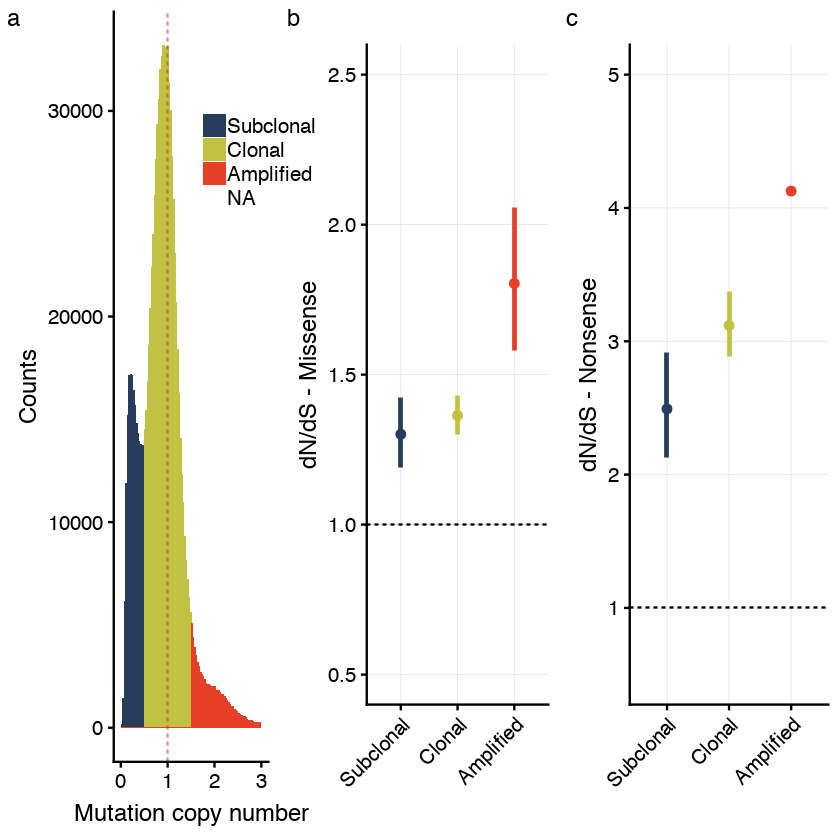

In [62]:
write_csv(dfdnds, "FinalFigures/data_for_figures/TCGA_dnds_clonality.csv")
library(jcolors)
gvafall <- dfsubc %>%
    mutate(clonality = factor(clonality, 
                              levels = c("Subclonal", "Clonal", "Amplified"))) %>%
    ggplot(aes(x = MCN, fill = clonality)) +
    geom_histogram(bins = 100, position = "identity") +
    geom_vline(xintercept = 1.0, lty = 2, col = "firebrick", alpha = 0.5) +
    xlim(c(0, 3.0)) +
    theme(legend.position = c(0.5, 0.8), legend.title = element_blank()) +
    xlab("Mutation copy number") + ylab("Counts") + 
    scale_fill_jcolors(palette = "pal9") #+scale_color_jcolors(palette = "pal9")


gdndsdriver <- getdndsplot(dfdnds, baseline, "wmis", "drivers", "Driver mutations", "dN/dS - Missense", ylims = c(0.5, 2.5)) +
                scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")
gdndsdrivernon <- getdndsplot(dfdnds, baseline, "wnon", "drivers", "Driver mutations", "dN/dS - Nonsense", ylims = c(0.5, 5.0)) +
                scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")



gclonality <- cowplot::plot_grid(gvafall, gdndsdriver, gdndsdrivernon, ncol = 3, labels = c("a", "b", "c"))
#save_plot("plots/1.TCGA/dndsclonality.pdf", gclonality, base_height = 3.5, base_width = 10)
gclonality

### Interval dN/dS for subclonal mutations

In [40]:
dfsubc <- df %>%
    filter(meaneffdepth > 50.0) %>%
    select(sampleid, chr, start, Reference_Allele, Tumor_Seq_Allele2, everything())

dfdnds.interval <- data.frame()
cutoff <- seq(0.2, 0.5, 0.025)

for (i in cutoff){
    x1 <- dfsubc %>% filter(MCN < i)
    
    x <- dndscv(x1 , gene_list = as.character(drivers$V1), outp = 1,
               refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(MCN = i, mutationtype = "drivers")
    dfdnds.interval <- rbind(dfdnds.interval, out)
    print(out)
    
    x <- dndscv(x1, outp = 1,
               refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
    out <- x$globaldnds %>% mutate(MCN = i, mutationtype = "all")
    dfdnds.interval <- rbind(dfdnds.interval, out)
}

[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...


  name       mle     cilow   cihigh MCN mutationtype
1 wmis 1.4149393 1.1921475 1.679367 0.2      drivers
2 wnon 2.8383339 2.1123005 3.813917 0.2      drivers
3 wspl 0.9935853 0.5869293 1.681994 0.2      drivers
4 wtru 2.1386065 1.6348195 2.797641 0.2      drivers
5 wall 1.4844340 1.2534925 1.757924 0.2      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 62 mutations removed for exceeding the limit of mutations per gene per sample
    22% ...
    44% ...
    67% ...
    89% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate 

  name      mle     cilow   cihigh   MCN mutationtype
1 wmis 1.405248 1.2054152 1.638210 0.225      drivers
2 wnon 2.668245 2.0462260 3.479347 0.225      drivers
3 wspl 1.115913 0.7123825 1.748025 0.225      drivers
4 wtru 2.092755 1.6455717 2.661460 0.225      drivers
5 wall 1.471610 1.2648476 1.712171 0.225      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 107 mutations removed for exceeding the limit of mutations per gene per sample
    18% ...
    35% ...
    53% ...
    70% ...
    88% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Ple

  name      mle     cilow   cihigh  MCN mutationtype
1 wmis 1.366509 1.1867726 1.573467 0.25      drivers
2 wnon 2.809433 2.2085842 3.573743 0.25      drivers
3 wspl 1.099180 0.7258049 1.664630 0.25      drivers
4 wtru 2.175182 1.7476235 2.707344 0.25      drivers
5 wall 1.442661 1.2552514 1.658052 0.25      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 150 mutations removed for exceeding the limit of mutations per gene per sample
    15% ...
    29% ...
    44% ...
    59% ...
    73% ...
    88% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a

  name       mle     cilow   cihigh   MCN mutationtype
1 wmis 1.3257562 1.1643279 1.509566 0.275      drivers
2 wnon 2.5714154 2.0505138 3.224644 0.275      drivers
3 wspl 0.9684756 0.6507949 1.441230 0.275      drivers
4 wtru 1.9718519 1.6048082 2.422844 0.275      drivers
5 wall 1.3883562 1.2213309 1.578223 0.275      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 205 mutations removed for exceeding the limit of mutations per gene per sample
    13% ...
    25% ...
    38% ...
    50% ...
    63% ...
    76% ...
    88% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous si

  name       mle     cilow   cihigh MCN mutationtype
1 wmis 1.3446915 1.1887588 1.521078 0.3      drivers
2 wnon 2.6076151 2.1069860 3.227196 0.3      drivers
3 wspl 0.9487484 0.6460642 1.393242 0.3      drivers
4 wtru 1.9999309 1.6457552 2.430327 0.3      drivers
5 wall 1.4090391 1.2476151 1.591349 0.3      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1 samples excluded for exceeding the limit of mutations per sample
    Note: 241 mutations removed for exceeding the limit of mutations per gene per sample
    12% ...
    23% ...
    35% ...
    46% ...
    58% ...
    69% ...
    81% ...
    92% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dn

  name      mle     cilow   cihigh   MCN mutationtype
1 wmis 1.361661 1.2110150 1.531046 0.325      drivers
2 wnon 2.628347 2.1484433 3.215447 0.325      drivers
3 wspl 1.009559 0.7051043 1.445473 0.325      drivers
4 wtru 2.045256 1.7008391 2.459416 0.325      drivers
5 wall 1.427362 1.2713141 1.602563 0.325      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3 samples excluded for exceeding the limit of mutations per sample
    Note: 202 mutations removed for exceeding the limit of mutations per gene per sample
    11% ...
    22% ...
    33% ...
    45% ...
    56% ...
    67% ...
    78% ...
    89% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dn

  name      mle     cilow   cihigh  MCN mutationtype
1 wmis 1.340746 1.1993783 1.498775 0.35      drivers
2 wnon 2.636880 2.1765093 3.194628 0.35      drivers
3 wspl 1.059912 0.7587384 1.480632 0.35      drivers
4 wtru 2.065977 1.7344179 2.460918 0.35      drivers
5 wall 1.409148 1.2623650 1.572997 0.35      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3 samples excluded for exceeding the limit of mutations per sample
    Note: 241 mutations removed for exceeding the limit of mutations per gene per sample
    10% ...
    20% ...
    31% ...
    41% ...
    51% ...
    61% ...
    71% ...
    81% ...
    92% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refd

  name      mle     cilow   cihigh   MCN mutationtype
1 wmis 1.303984 1.1731703 1.449384 0.375      drivers
2 wnon 2.480056 2.0617630 2.983213 0.375      drivers
3 wspl 1.006659 0.7270782 1.393745 0.375      drivers
4 wtru 1.953211 1.6502251 2.311827 0.375      drivers
5 wall 1.365174 1.2298663 1.515369 0.375      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3 samples excluded for exceeding the limit of mutations per sample
    Note: 297 mutations removed for exceeding the limit of mutations per gene per sample
    9% ...
    19% ...
    28% ...
    38% ...
    47% ...
    56% ...
    66% ...
    75% ...
    85% ...
    94% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), out

  name       mle     cilow   cihigh MCN mutationtype
1 wmis 1.2969308 1.1712418 1.436108 0.4      drivers
2 wnon 2.4824433 2.0778634 2.965799 0.4      drivers
3 wspl 0.9992276 0.7295493 1.368593 0.4      drivers
4 wtru 1.9523825 1.6597452 2.296616 0.4      drivers
5 wall 1.3582580 1.2282169 1.502068 0.4      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 4 samples excluded for exceeding the limit of mutations per sample
    Note: 314 mutations removed for exceeding the limit of mutations per gene per sample
    9% ...
    18% ...
    27% ...
    36% ...
    45% ...
    54% ...
    63% ...
    72% ...
    81% ...
    90% ...
    99% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(driv

  name      mle     cilow   cihigh   MCN mutationtype
1 wmis 1.286219 1.1653920 1.419572 0.425      drivers
2 wnon 2.453045 2.0648689 2.914196 0.425      drivers
3 wspl 1.015028 0.7500327 1.373648 0.425      drivers
4 wtru 1.942061 1.6596483 2.272530 0.425      drivers
5 wall 1.347240 1.2222156 1.485053 0.425      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 4 samples excluded for exceeding the limit of mutations per sample
    Note: 360 mutations removed for exceeding the limit of mutations per gene per sample
    8% ...
    17% ...
    25% ...
    34% ...
    42% ...
    51% ...
    59% ...
    67% ...
    76% ...
    84% ...
    93% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(driv

  name      mle     cilow   cihigh  MCN mutationtype
1 wmis 1.304743 1.1854547 1.436036 0.45      drivers
2 wnon 2.485370 2.1037197 2.936258 0.45      drivers
3 wspl 1.088854 0.8164025 1.452228 0.45      drivers
4 wtru 1.994417 1.7133331 2.321614 0.45      drivers
5 wall 1.368479 1.2448864 1.504342 0.45      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5 samples excluded for exceeding the limit of mutations per sample
    Note: 384 mutations removed for exceeding the limit of mutations per gene per sample
    8% ...
    16% ...
    24% ...
    32% ...
    41% ...
    49% ...
    57% ...
    65% ...
    73% ...
    81% ...
    89% ...
    97% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.ch

  name      mle     cilow   cihigh   MCN mutationtype
1 wmis 1.316305 1.1989857 1.445103 0.475      drivers
2 wnon 2.465497 2.0964680 2.899484 0.475      drivers
3 wspl 1.095120 0.8301709 1.444627 0.475      drivers
4 wtru 1.980391 1.7087143 2.295263 0.475      drivers
5 wall 1.378401 1.2570316 1.511488 0.475      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 5 samples excluded for exceeding the limit of mutations per sample
    Note: 427 mutations removed for exceeding the limit of mutations per gene per sample
    8% ...
    15% ...
    23% ...
    31% ...
    38% ...
    46% ...
    54% ...
    61% ...
    69% ...
    77% ...
    84% ...
    92% ...
    100% ...
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene

  name      mle     cilow   cihigh MCN mutationtype
1 wmis 1.301226 1.1887701 1.424320 0.5      drivers
2 wnon 2.492821 2.1305445 2.916698 0.5      drivers
3 wspl 1.125045 0.8625158 1.467482 0.5      drivers
4 wtru 2.006855 1.7399483 2.314706 0.5      drivers
5 wall 1.366820 1.2501703 1.494353 0.5      drivers


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 6 samples excluded for exceeding the limit of mutations per sample
    Note: 446 mutations removed for exceeding the limit of mutations per gene per sample
    7% ...
    15% ...
    22% ...
    30% ...
    37% ...
    44% ...
    52% ...
    59% ...
    67% ...
    74% ...
    81% ...
    89% ...
    96% ...
[3] Estimating global rates...


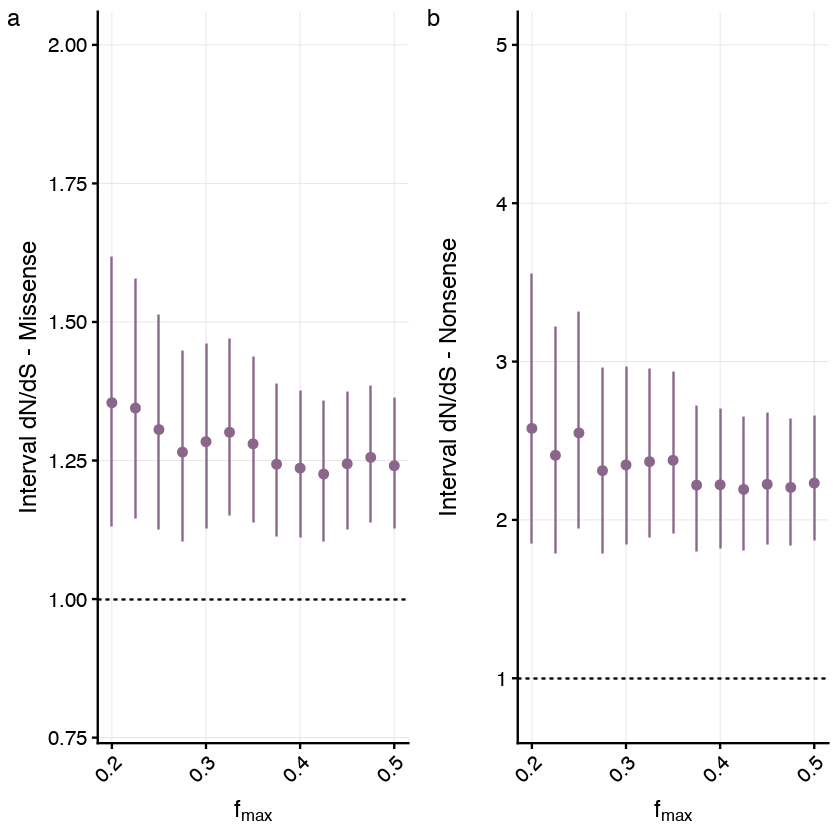

In [41]:
dfdndsInt <- dfdnds.interval %>%
    left_join(., baseline, by = "name") %>%
    mutate(mle = mle - (dnds_bl - 1),
          cilow = cilow - (dnds_bl - 1),
          cihigh = cihigh - (dnds_bl - 1))
write_csv(dfdndsInt, "FinalFigures/data_for_figures/IntervalDnDs_tcga.csv")

gmissInt <- dfdndsInt %>%
    filter(name == "wmis", mutationtype ==  "drivers") %>%
    ggplot(aes(x = MCN, y = mle, ymin = cilow, ymax = cihigh)) +
    geom_point(size = 2, col = "plum4") +
    geom_linerange(col = "plum4") +
    geom_hline(yintercept = 1.0, lty = 2) +
    background_grid(major = "xy", minor = "none") +
    ylab("Interval dN/dS - Missense") + xlab(expression(f[max])) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_color_ptol() + ylim(c(0.8, 2.0))

gnonInt <- dfdndsInt %>%
    filter(name == "wnon", mutationtype ==  "drivers") %>%
    ggplot(aes(x = MCN, y = mle, ymin = cilow, ymax = cihigh)) +
    geom_point(size = 2, col = "plum4") +
    geom_linerange(col = "plum4") +
    geom_hline(yintercept = 1.0, lty = 2) +
    background_grid(major = "xy", minor = "none") +
    ylab("Interval dN/dS - Nonsense") + xlab(expression(f[max])) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_color_ptol() + ylim(c(0.8, 5.0))
gInt <- cowplot::plot_grid(gmissInt, gnonInt, ncol = 2, align = T, labels = c("a", "b"))
#save_plot("plots/1.TCGA/intervaldnds.svg", gInt, base_height = 3.5, base_width = 10)
gInt

### Per cancer type

In [42]:
dfsubc %>%
    distinct(sampleid, cancertype) %>%
    group_by(cancertype) %>%
    summarise(n = n())

cancertype,n
ACC,22
BLCA,52
BRCA,270
CESC,24
COAD,199
DLBC,9
GBM,253
HNSC,103
KICH,31
KIRC,186


In [43]:
dfsubc <- df %>%
    filter(meaneffdepth > 50.0) %>% #remove samples with effective depth < 50X
    select(sampleid, chr, start, Reference_Allele, Tumor_Seq_Allele2, everything())

cancertypes <- dfsubc %>%
    distinct(sampleid, cancertype) %>%
    group_by(cancertype) %>%
    summarise(n = n()) %>%
    filter(n >= 100) %>%
    #filter(!cancertype %in% c("THCA", "PRAD")) %>%
    pull(cancertype)

dfdnds.cancertype <- data.frame()

for (ct in cancertypes){
    print(ct)
    for (clon in c("Subclonal", "Clonal", "Amplified")){
        x1 <- dfsubc %>% filter(clonality == clon, cancertype == ct)

        x <- dndscv(x1 , gene_list = as.character(drivers$V1), outp = 1,
                   refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
        out <- x$globaldnds %>% mutate(clonality = clon, mutationtype = "drivers", cancertype = ct)
        dfdnds.cancertype <- rbind(dfdnds.cancertype, out)

        x <- dndscv(x1, outp = 1,
                   refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")
        out <- x$globaldnds %>% mutate(clonality = clon, mutationtype = "all", cancertype = ct)
        dfdnds.cancertype <- rbind(dfdnds.cancertype, out)
    }
}

dfdnds.cancertype <- dfdnds.cancertype %>%
    mutate(clonality = factor(clonality, 
                              levels = c("Subclonal", "Clonal", "Amplified")))

[1] "BRCA"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "COAD"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 3 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove d

[1] "GBM"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "HNSC"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "KIRC"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "LGG"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”    Note: 1 samples excluded for exceeding the limit of mutations per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p1

[1] "LUSC"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "OV"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, ou

[1] "PRAD"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please anno

[1] "SKCM"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 1 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove d

[1] "THCA"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
Warning message:
“glm.fit: fitted rates numerically 0 occurred”[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex s

[1] "UCEC"


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = as.character(drivers$V1), outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 10 mutations removed for exceeding the limit of mutations per gene per sample
[3] Estimating global rates...
[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove 

In [44]:
write_csv(dfdnds.cancertype, "FinalFigures/data_for_figures/TCGA_dnds_clonality_percancertype.csv")

In [45]:
plotlist <- list()
i <- 1
for (ct in cancertypes){
    
    dfdndsct <- dfdnds.cancertype %>%
        filter(cancertype == ct)
    
    gvafall <- dfsubc %>%
        filter(cancertype == ct) %>%
        mutate(clonality = factor(clonality, 
                                  levels = c("Subclonal", "Clonal", "Amplified"))) %>%
        ggplot(aes(x = MCN, fill = clonality)) +
        geom_histogram(bins = 100, position = "identity") +
        geom_vline(xintercept = 1.0, lty = 2, col = "firebrick", alpha = 0.5) +
        xlim(c(0, 3.0)) +
        theme(legend.position = c(0.5, 0.8), legend.title = element_blank()) +
        xlab("Mutation copy number") + ylab("Counts") + 
        scale_fill_jcolors(palette = "pal9") +
        ggtitle(ct)

    
    lim <- round(max(filter(dfdndsct, name == "wmis")$cihigh)) + 0.5
    gdndsdriver <- getdndsplot(dfdndsct, baseline, "wmis", "drivers", "Driver mutations", "dN/dS - Missense", ylims = c(0.0, lim)) +
                    scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")
    lim <- round(max(filter(dfdndsct, name == "wnon")$cihigh)) + 0.5
    gdndsdrivernon <- getdndsplot(dfdndsct, baseline, "wnon", "drivers", "Driver mutations", "dN/dS - Nonsense", ylims = c(0.0, lim)) +
                    scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")


    gclonality <- plot_grid(gvafall, gdndsdriver, gdndsdrivernon, ncol = 3)
    
    plotlist[[i]] <- gclonality
    i <- i + 1
}

save_plot("plots/1.TCGA/figureSX-dnds-percancertype-drivers.pdf", plot_grid(plotlist = plotlist, ncol = 2), 
          base_height = 20,
          base_width = 20)


plotlist <- list()
i <- 1
for (ct in cancertypes){
    
    dfdndsct <- dfdnds.cancertype %>%
        filter(cancertype == ct)
    
    gvafall <- dfsubc %>%
        filter(cancertype == ct) %>%
        mutate(clonality = factor(clonality, 
                                  levels = c("Subclonal", "Clonal", "Amplified"))) %>%
        ggplot(aes(x = MCN, fill = clonality)) +
        geom_histogram(bins = 100, position = "identity") +
        geom_vline(xintercept = 1.0, lty = 2, col = "firebrick", alpha = 0.5) +
        xlim(c(0, 3.0)) +
        theme(legend.position = c(0.5, 0.8), legend.title = element_blank()) +
        xlab("Mutation copy number") + ylab("Counts") + 
        scale_fill_jcolors(palette = "pal9") +
        ggtitle(ct)

    
    lim <- round(max(filter(dfdndsct, name == "wmis", mutationtype == "all")$cihigh)) + 0.5
    gdndsdriver <- getdndsplot(dfdndsct, baseline, "wmis", "all", "Driver mutations", "dN/dS - Missense", ylims = c(0.8, lim)) +
                    scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")
    lim <- round(max(filter(dfdndsct, name == "wnon", mutationtype == "all")$cihigh)) + 0.5
    gdndsdrivernon <- getdndsplot(dfdndsct, baseline, "wnon", "all", "Driver mutations", "dN/dS - Nonsense", ylims = c(0.8, lim)) +
                    scale_color_jcolors(palette = "pal9") + theme(legend.position = "none") + ggtitle("")


    gclonality <- plot_grid(gvafall, gdndsdriver, gdndsdrivernon, ncol = 3)
    
    plotlist[[i]] <- gclonality
    i <- i + 1
}

save_plot("plots/1.TCGA/figureSX-dnds-percancertype-WXS.pdf", plot_grid(plotlist = plotlist, ncol = 2), 
          base_height = 20,
          base_width = 20)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Warning message:
“Removed 209 rows containing non-finite values (stat_bin).”Warning message:
“Removed 6 rows containing missing values (geom_bar).”Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Warning message:
“Removed 619 rows containing non-finite values (stat_bin).”Warning message:
“Removed 6 rows containing missing values (geom_bar).”Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Warning message:
“Removed 65

### Number of mutations per gene

For some of the analysis it is useful to know how many mutations in particular genes there are per cancer.

In [7]:
dftemp <- df %>%
    select(sampleid, chr, start, Reference_Allele, Tumor_Seq_Allele2, everything())

#we'll use dndscv to annotate the mutations to be consistent
x <- dndscv(dftemp, outp = 1, 
                refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda")

dfannot <- x$annotmuts

[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(dftemp, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(dftemp, outp = 1, refdb = "data/dndscv/dndscv_data/data/RefCDS_human_GRCh38.p12.rda"):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”    Note: 75 samples excluded for exceeding the limit of mutations per sample
    Note: 2395 mutations removed for exceeding the limit of mutations per gene per sample
    1% ...
    3% ...
    4% ...
    6% ...
    7% ...
    9% ...
    10% ...
    11% ...
    13% ...
    14% ...
    16% ...
    17% ...
    19% ...
    20% ...
    21% ...
    23% ...
    24% ...
    26% ...
    27% ...
    29% ...
    30% ...
    31% ...
    33% ...
    

In [12]:
df2 <- df %>%
dplyr::rename(pos = start, ref = Reference_Allele, sampleID = sampleid, mut = Tumor_Seq_Allele2)

df2 <- left_join(df2, dfannot, by = c("sampleID", "chr", "pos", "ref", "mut"))

In [28]:
df2 %>%
filter(gene %in% drivers$V1, clonality == "Subclonal", MCN > 0.2)  %>%
group_by(gene, impact) %>%
summarise(n = n()) %>%
write_csv(., "FinalFigures/data_for_figures/TCGA_mutation_pergene.csv")

df2 %>%
filter(gene %in% drivers$V1, clonality == "Subclonal", MCN > 0.2)  %>%
group_by(gene, impact, cancertype) %>%
summarise(n = n()) %>%
write_csv(., "FinalFigures/data_for_figures/TCGA_mutation_pergene_percancertype.csv")

Warning message:
“Removed 216 rows containing non-finite values (stat_bin).”Warning message:
“Removed 6 rows containing missing values (geom_bar).”

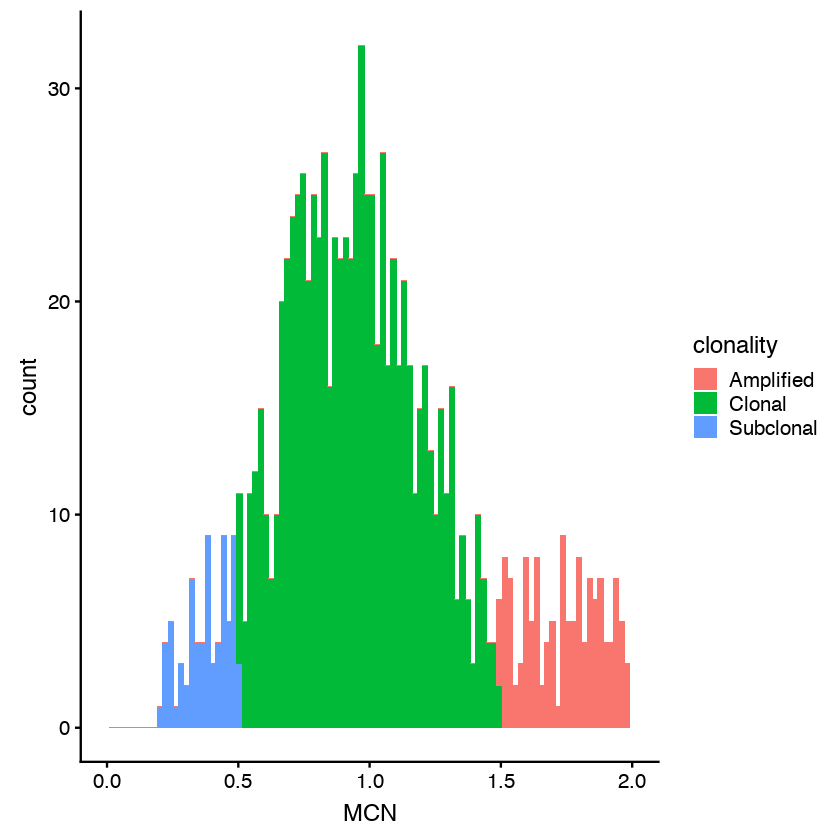

In [26]:
df2 %>%
filter(gene == "TP53", MCN > 0.2) %>%
ggplot(aes(x = MCN, fill = clonality)) +
geom_histogram(bins = 100) +
xlim(c(0, 2))